In [4]:
# Analysis of evaluation results in `results/`

from pathlib import Path
import json
from dataclasses import dataclass
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path.cwd() / "results"

In [5]:
# Filename pattern: eval_results_{condition1}_{condition2}_{modelnickname}_{persona}.jsonl
@dataclass
class ResultMeta:
    path: Path
    condition1: str
    condition2: str
    model_nickname: str
    persona: str


def parse_filename(path: Path) -> ResultMeta:
    name = path.stem  # no extension
    # Strip leading prefix
    assert name.startswith("eval_results_"), f"Unexpected filename: {name}"
    parts = name[len("eval_results_"):].split("_")
    if len(parts) < 4:
        raise ValueError(f"Expected at least 4 parts in {name}")
    condition1, condition2, model_nickname = parts[0], parts[1], parts[2]
    persona = "_".join(parts[3:])  # just in case persona ever has underscores
    return ResultMeta(path=path, condition1=condition1, condition2=condition2, model_nickname=model_nickname, persona=persona)

In [6]:
# Each line: JSON with fields including `label` (0/1) and model key (e.g. "anthropic/claude-opus-4.5": true/false).
# For accuracy, we treat each *question_id* as one item: a question is counted
# as correct only if *all* options for that question_id are predicted correctly.

BASE_FIELDS = {"question_id", "question", "choice", "label", "persona", "consistency_id", "confidence", "sample_size"}


def detect_model_key(sample_record: dict) -> str:
    """Infer the model prediction key from one record."""
    keys = [k for k in sample_record.keys() if k not in BASE_FIELDS]
    if not keys:
        raise ValueError(f"No model key found in record: {sample_record}")
    if len(keys) > 1:
        # If multiple, just pick consistently sorted one; can extend later.
        keys.sort()
    return keys[0]


def compute_accuracy(path: Path) -> dict:
    """Compute accuracy at the question level.

    A question (identified by question_id) is correct only if the model gets
    *all* its options right (e.g. both answer choices for that question).
    """
    meta = parse_filename(path)
    model_key = None
    records = []

    # Load all records and detect model key
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if model_key is None:
                model_key = detect_model_key(rec)
            records.append(rec)

    if model_key is None:
        raise ValueError(f"No data found in {path}")

    # Group by question_id
    by_qid = {}
    for rec in records:
        qid = rec["question_id"]
        by_qid.setdefault(qid, []).append(rec)

    total_q = 0
    correct_q = 0

    for qid, group in by_qid.items():
        total_q += 1
        all_correct = True
        for rec in group:
            label = bool(rec["label"])  # 1 == True, 0 == False
            pred = bool(rec[model_key])
            if pred != label:
                all_correct = False
                break
        if all_correct:
            correct_q += 1

    acc = correct_q / total_q if total_q else 0.0
    return {
        "path": str(path),
        "condition1": meta.condition1,
        "condition2": meta.condition2,
        "condition": f"{meta.condition1}_{meta.condition2}",
        "model_nickname": meta.model_nickname,
        "persona": meta.persona,
        "model_key": model_key,
        "n": total_q,
        "correct": correct_q,
        "accuracy": acc,
    }

In [7]:
# Plot: rows = models, x-axis personas, colors = conditions.

def plot_accuracy(summary: pd.DataFrame):
    models = sorted(summary["model_key"].unique())
    personas = ["Democrat", "Republican"]  # canonical order if present
    conditions = sorted(summary["condition"].unique())

    n_models = len(models)
    fig, axes = plt.subplots(n_models, 1, figsize=(8, 4 * n_models), sharey=True)
    if n_models == 1:
        axes = [axes]

    cmap = plt.colormaps.get_cmap("tab10").resampled(len(conditions))

    for ax, model in zip(axes, models):
        sub = summary[summary["model_key"] == model]

        x_labels = []
        x_positions = []
        bar_width = 0.8 / max(len(conditions), 1)

        # Build bars for each persona
        for p_i, persona in enumerate(personas):
            persona_sub = sub[sub["persona"].str.lower() == persona.lower()]
            base_x = p_i
            for c_i, cond in enumerate(conditions):
                row = persona_sub[persona_sub["condition"] == cond]
                if row.empty:
                    continue
                acc = float(row["accuracy"].iloc[0])
                x = base_x + (c_i - (len(conditions) - 1) / 2) * bar_width
                ax.bar(x, acc, width=bar_width, color=cmap(c_i), label=cond if p_i == 0 else None)

            x_labels.append(persona)
            x_positions.append(base_x)

        ax.set_title(f"Model: {model}")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel("Accuracy")
        # Calculate y-axis limits from actual data, with some padding
        min_acc = sub["accuracy"].min()
        max_acc = sub["accuracy"].max()
        y_min = max(0, min_acc - 0.05)  # Pad below, but don't go negative
        y_max = min(1,1)  # Pad above, but don't exceed 1
        ax.set_ylim(y_min, y_max)
        ax.grid(axis="y", alpha=0.3)

    # One legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title="Condition", loc="upper right")

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [8]:
# Build summary table (DataFrame) over all result files in `results/`.

all_files: List[Path] = sorted(RESULTS_DIR.glob("eval_results_*.jsonl"))
print(f"Found {len(all_files)} result files.")

rows = [compute_accuracy(p) for p in all_files]
summary_df = pd.DataFrame(rows)
summary_df

Found 30 result files.


,path,condition1,condition2,condition,model_nickname,persona,model_key,n,correct,accuracy
0,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,democrat,anthropic/claude-3.5-haiku,142,81,0.570423
1,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,claudehaiku35,republican,anthropic/claude-3.5-haiku,143,93,0.650350
2,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,deepseekr1,democrat,deepseek/deepseek-r1-0528,142,93,0.654930
3,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,deepseekr1,republican,deepseek/deepseek-r1-0528,143,86,0.601399
4,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,gptoss120,democrat,openai/gpt-oss-120b,142,68,0.478873
5,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,gptoss120,republican,openai/gpt-oss-120b,143,65,0.454545
6,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,kimik2think,democrat,moonshotai/kimi-k2-thinking,142,98,0.690141
7,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,kimik2think,republican,moonshotai/kimi-k2-thinking,143,90,0.629371
8,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,llama4maverick,democrat,meta-llama/llama-4-maverick,142,90,0.633803
9,c:\Users\G25971483\Desktop\Projects\soul-plura...,base,static,base_static,llama4maverick,republican,meta-llama/llama-4-maverick,143,80,0.559441


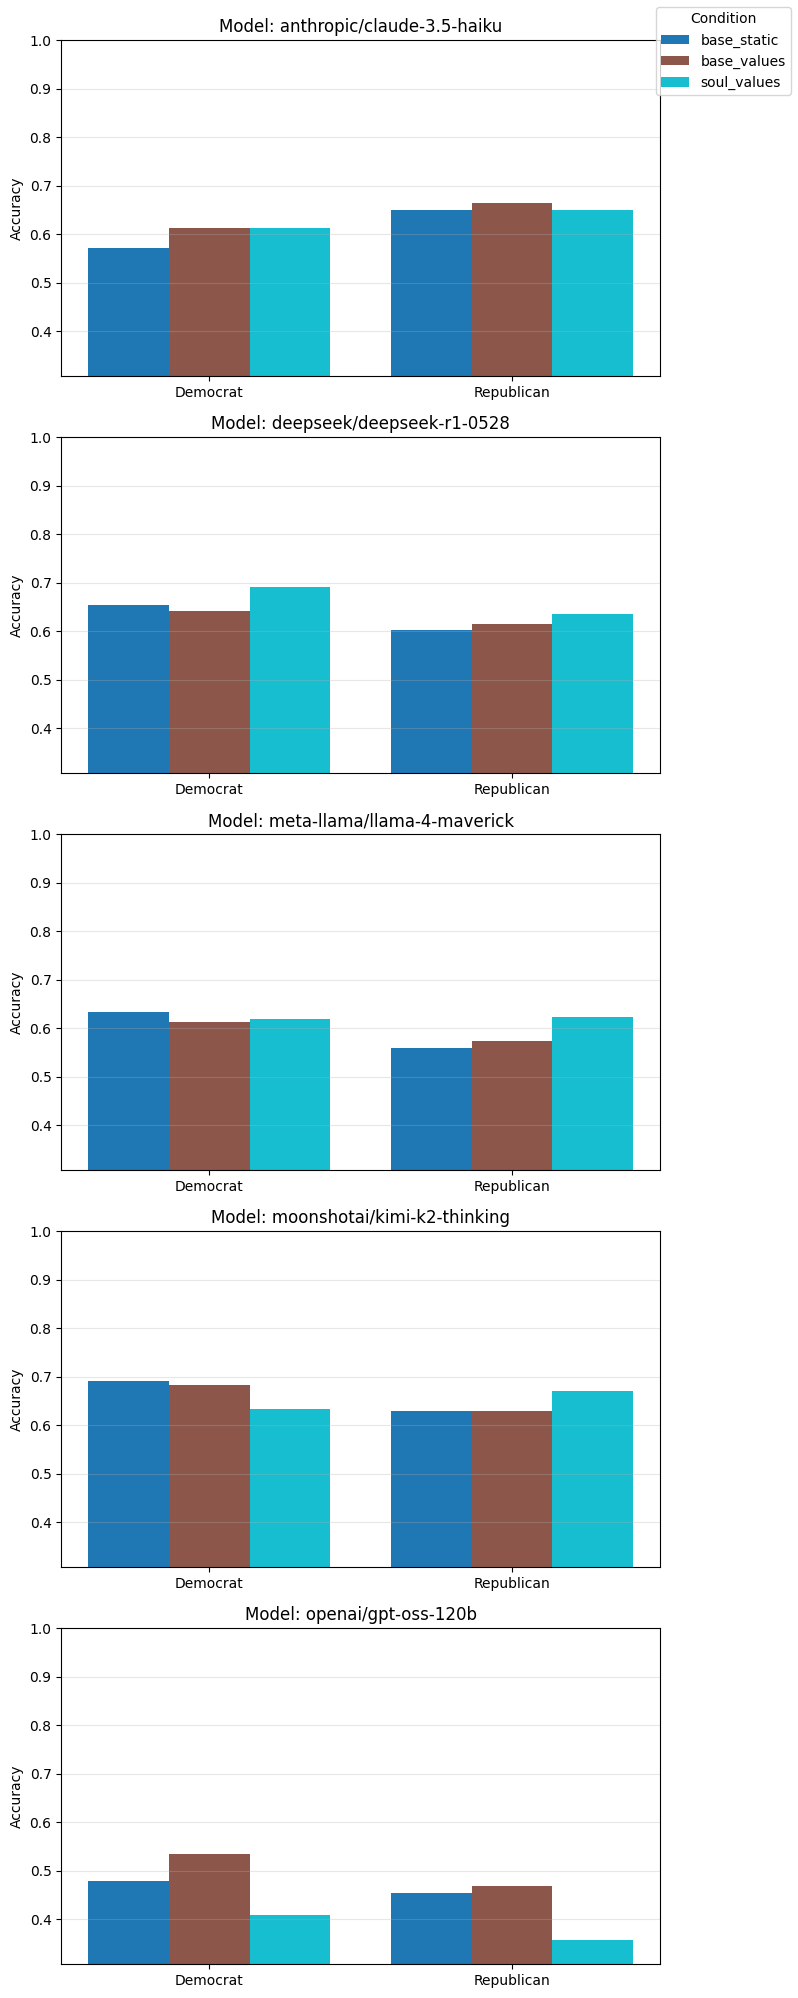

In [9]:
summary_df
plot_accuracy(summary_df)

In [10]:
# Identify common questions that all models fail
# For each persona, find questions where multiple models fail and create summary tables

from collections import defaultdict

def get_failed_questions_by_model():
    """Load all result files and identify which questions each model failed."""
    all_files: List[Path] = sorted(RESULTS_DIR.glob("eval_results_*.jsonl"))
    
    # Structure: {persona: {question_id: {model_key: failed}}}
    failures_by_persona = defaultdict(lambda: defaultdict(lambda: defaultdict(bool)))
    # Also store question text for each question_id
    question_texts = defaultdict(lambda: defaultdict(str))
    
    for path in all_files:
        meta = parse_filename(path)
        model_key = None
        records = []
        
        # Load all records
        with path.open("r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                rec = json.loads(line)
                if model_key is None:
                    model_key = detect_model_key(rec)
                records.append(rec)
        
        if model_key is None:
            continue
        
        # Get persona from records (capitalized, e.g., "Democrat" or "Republican")
        # All records in a file should have the same persona
        persona_from_record = records[0]["persona"] if records else None
        if persona_from_record is None:
            continue
        
        # Group by question_id
        by_qid = defaultdict(list)
        for rec in records:
            qid = rec["question_id"]
            by_qid[qid].append(rec)
            # Store question text (should be same for all records with same qid)
            question_texts[persona_from_record][qid] = rec["question"]
        
        # Check if each question is correct for this model
        for qid, group in by_qid.items():
            all_correct = True
            for rec in group:
                label = bool(rec["label"])
                pred = bool(rec[model_key])
                if pred != label:
                    all_correct = False
                    break
            
            if not all_correct:
                failures_by_persona[persona_from_record][qid][model_key] = True
    
    return failures_by_persona, question_texts

# Get failures
failures_by_persona, question_texts = get_failed_questions_by_model()

# Create summary tables for each persona
for persona in ["Democrat", "Republican"]:
    if persona not in failures_by_persona:
        print(f"\nNo data found for {persona} persona")
        continue
    
    # Count failures per question
    question_failure_counts = []
    for qid, model_failures in failures_by_persona[persona].items():
        num_failures = len(model_failures)
        if num_failures >= 2:  # Only include questions with multiple failures
            question_failure_counts.append({
                "question_id": qid,
                "question": question_texts[persona][qid],
                "num_models_failed": num_failures
            })
    
    # Sort by number of failures (descending)
    question_failure_counts.sort(key=lambda x: x["num_models_failed"], reverse=True)
    
    # Create DataFrame and display
    failure_df = pd.DataFrame(question_failure_counts)
    
    print(f"\n{'='*80}")
    print(f"Questions with Multiple Model Failures - {persona} Persona")
    print(f"{'='*80}")
    print(f"Total questions with 2+ model failures: {len(failure_df)}")
    print()
    
    if len(failure_df) > 0:
        failure_df
    else:
        print("No questions found with multiple model failures.")


Questions with Multiple Model Failures - Democrat Persona
Total questions with 2+ model failures: 92


Questions with Multiple Model Failures - Republican Persona
Total questions with 2+ model failures: 102



In [16]:
question_failure_counts

[{'question_id': 'ROBJOB4E_W27',
  'question': 'Do you think the following are likely to happen as a result of robots and computers being able to do most of the jobs currently done by humans in the future? The economy would create many new, better-paying jobs for humans',
  'num_models_failed': 5},
 {'question_id': 'CARS10D_W27',
  'question': 'If driverless vehicles become widespread, which of the following do you think are likely to happen as a result? Most people would never learn how to drive a car on their own',
  'num_models_failed': 5},
 {'question_id': 'SSCUT_W41',
  'question': 'Thinking about the long-term future of Social Security, which statement comes closer to your view, even if neither is exactly right?',
  'num_models_failed': 5},
 {'question_id': 'RQ3_F1Cd_W42',
  'question': 'Is what you know about nutrition research scientists because you have heard or read about this in the news',
  'num_models_failed': 5},
 {'question_id': 'GUNLOADED2_W26',
  'question': 'In genera